# ARIMA with pyramid
This notebook shows how to use the ARIMA-algorithm for forecasting univariate time series. To make things simple the [Pyramid Library](https://github.com/alkaline-ml/pmdarima) is used.

In case you do not know ARIMA, have a quick look on the [wikipedia article](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average).

In [ ]:
# First install the required packages
!pip install matplotlib numpy pandas pmdarima

In [1]:
import pandas as pd
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Load Data

In this example we will use the average temperature of the earth surface and make a prediction how this value will evolve.
The source of the data can be found at Kaggle: https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

In [3]:
# Load data
df = pd.read_csv("data/GlobalTemperatures.csv", parse_dates=[0])
df = df[["dt", "LandAverageTemperature"]]
df["LandAverageTemperature"] = df["LandAverageTemperature"].interpolate()
ds_temp = df["LandAverageTemperature"]

## Create train and test data
You can either slpit by percentage or pick a start/end data. So you can decide which of the following two cells you want to run.

In [5]:
# split data by percentage
split_percentage = 80
train_size = int(ds_temp.shape[0]*(split_percentage/100))
train, test = train_test_split(ds_temp, train_size=train_size)

In [7]:
# split data by year
train_start_date = '1900-01-01'
train_end_date = '1999-12-01'
test_start_date = '2000-01-01'
test_end_date = '2015-12-01'

train = df[(df["dt"] >= train_start_date) & (df["dt"] <= train_end_date)]["LandAverageTemperature"]
test = df[(df["dt"] >= test_start_date) & (df["dt"] <= test_end_date)]["LandAverageTemperature"]

## Fit the model an create forecasts

The `auto_arima` method of pyramid automatically fits the ARIMA model.
Within this function multiple parameters can be specified for the seasonality:
- seasonal: boolean variable that indicates that the values of the time series are repeated with a defined frequency.
- m: this value defines the frequency, so how many data points occur per year/per season. In this case 12 is needed, as the average temperatures per month are used.

In [10]:
%%time
# Measure the execution time of the model fitting

# Fit model
model = pm.auto_arima(train, seasonal=True, m=12)

Wall time: 3min 19s


With `model.summary()` you can get an insight into the fitted model and see what parameters were calculated by the `auto_arima` function.

In [23]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 1200
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -322.446
Date:                              Sun, 25 Oct 2020   AIC                            654.892
Time:                                      20:45:43   BIC                            680.343
Sample:                                           0   HQIC                           664.479
                                             - 1200                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.000      3.227      0.001       0.000       0.002
ar.L1          0.4255      0.024     17.702      0.000       0.378       0.473
ar.S.L12       0.9998   6.48e-05   1.54e+04      0.000       1.000       1.000
ma.S.L12      -0.8718      0.014    -60.383      0.000      -0.900      -0.843
sigma2         0.0948      0.003     31.491      0.000       0.089       0.101
===================================================================================
Ljung-Box (Q):                       78.72   Jarque-Bera (JB):                96.69
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.08
Prob(H) (two-sided):                  0.91   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Create Forecasts
With the fitted model, future datapoints can be predicted.
In this case, the amount of test datapoints is predicted, so that later the test data can be compared with the prediction.

In [24]:
# Create forecasts
forecasts = model.predict(test.shape[0])

## Visualizations

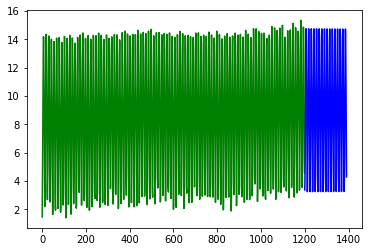

In [25]:
# Visualize the forecasts (green=train, blue=forecasts)
x = np.arange(train.shape[0] + test.shape[0])
plt.plot(x[:train.shape[0]], train, c='green')
plt.plot(x[train.shape[0]:], forecasts, c='blue')
plt.show()

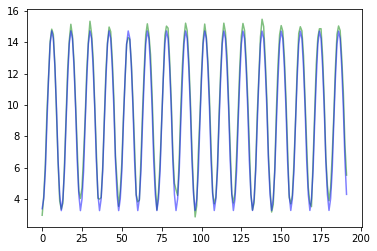

In [26]:
# Compare forecasts and real values (green=test, blue=forecasts)
x = np.arange(test.shape[0])
plt.plot(x, test, c='green', alpha=0.5)
plt.plot(x, forecasts, c='blue', alpha=0.5)
plt.show()

## Conclusion

The last figure demonstrates, how the forecasts and the real (test) values compare to each other.

Overall ARIMA's prediction seems to be quite appropriate. Only the temperature peaks in summer are not predicted as well. 